### Task 2 – Bayesian Change Point Detection on Brent Crude Oil Prices (2012–2022 focus)
**Objective**  
Identify structural breaks (mean shifts) using a single change-point Bayesian model in PyMC, quantify impacts, and associate detected breaks with major geopolitical/OPEC events.

In [10]:
# Cell 1 – Imports & path setup
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

from src.data_loader import BrentDataLoader
from src.data_preprocessor import BrentDataPreprocessor

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

In [11]:
# Cell 2 – Load data (full + 2012+ focus)
loader = BrentDataLoader()  
df_raw = loader.load()

prep = BrentDataPreprocessor(df_raw)
df_full = prep.add_features(focus_period=None)  # full for comparison
df = prep.get_processed(focus_period='2012-01-01')  # focus period

prices = df['Price'].values
dates = df.index

print(f"Full data range: {df_full.index.min():%Y-%m-%d} to {df_full.index.max():%Y-%m-%d}")
print(f"Focus period: {df.index.min():%Y-%m-%d} to {df.index.max():%Y-%m-%d}")
print(f"Observations in focus: {len(df):,}")

df.head(3)

Raw data loaded: 9011 rows, 2 columns
Data loaded successfully: 1987-05-20 to 2022-11-14
Total observations: 9011
Subset to >= 2012-01-01: 2760 observations remain
Full data range: 1987-05-20 to 2022-11-14
Focus period: 2012-01-03 to 2022-11-14
Observations in focus: 2,760


,Price,log_price,log_return,rolling_vol_30d
Date,,,,
2012-01-03,111.12,4.710611,0.027646,0.249638
2012-01-04,113.37,4.730657,0.020046,0.245764
2012-01-05,113.59,4.732595,0.001939,0.241938


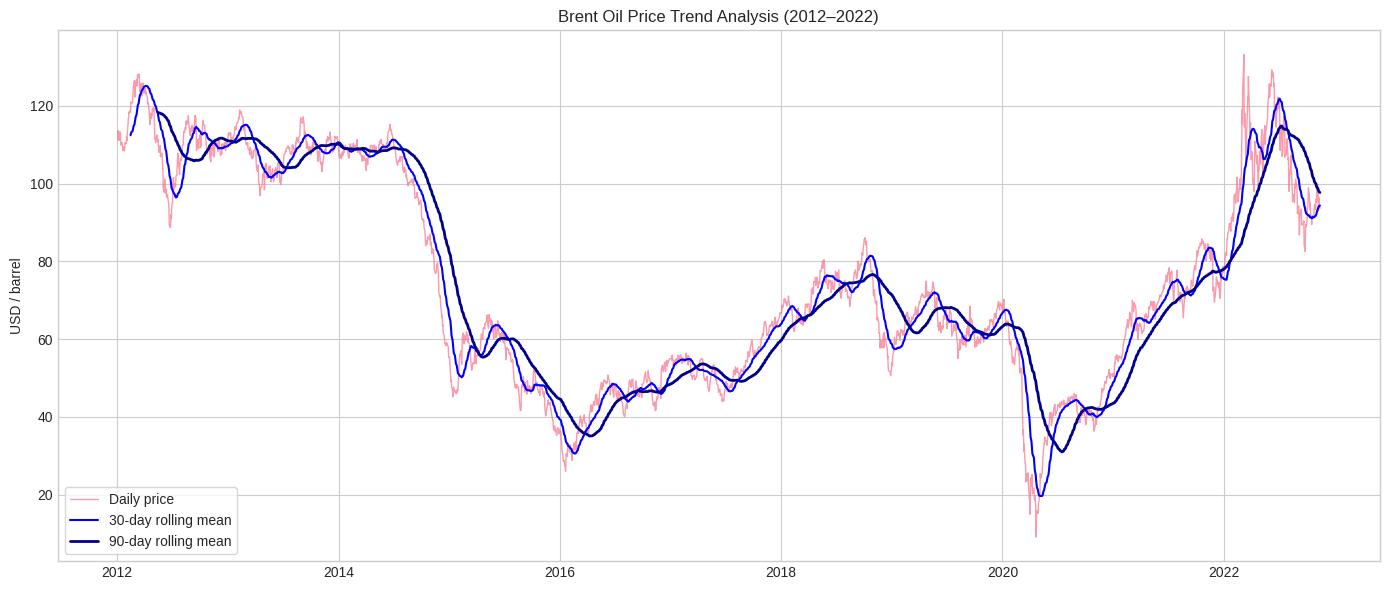

Narrative: The plot shows multi-year cycles, with a major downtrend starting 2014, crash in 2020, and spike in 2022. Rolling means highlight long-term trends vs short-term noise.


In [12]:
# Cell 3 – Trend analysis: raw price + rolling means
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Price'], lw=1.0, alpha=0.7, label='Daily price')
ax.plot(df['Price'].rolling(30).mean(), color='blue', lw=1.5, label='30-day rolling mean')
ax.plot(df['Price'].rolling(90).mean(), color='darkblue', lw=2.0, label='90-day rolling mean')

ax.set_title('Brent Oil Price Trend Analysis (2012–2022)')
ax.set_ylabel('USD / barrel')
ax.legend(frameon=True)
plt.tight_layout()
plt.show()

print("Narrative: The plot shows multi-year cycles, with a major downtrend starting 2014, crash in 2020, and spike in 2022. Rolling means highlight long-term trends vs short-term noise.")

In [13]:
# Cell 4 – Stationarity testing (ADF)
def adf_report(series, title):
    res = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{title}")
    print(f"  ADF statistic     : {res[0]:.4f}")
    print(f"  p-value           : {res[1]:.6f}")
    print(f"  Stationary?       : {'YES' if res[1] < 0.05 else 'NO'}")
    print(f"  Critical values   : {res[4]}")

adf_report(df['Price'], "Raw prices (non-stationary expected)")
adf_report(df['log_price'], "Log prices")
adf_report(df['log_return'], "Log returns (stationary expected)")

print("Narrative: Raw/log prices are non-stationary due to trends; log returns are stationary, informing that change point modeling on levels is appropriate for regime shifts.")


Raw prices (non-stationary expected)
  ADF statistic     : -2.2076
  p-value           : 0.203484
  Stationary?       : NO
  Critical values   : {'1%': np.float64(-3.4327458473129906), '5%': np.float64(-2.86259851213211), '10%': np.float64(-2.5673334803017864)}

Log prices
  ADF statistic     : -2.6647
  p-value           : 0.080347
  Stationary?       : NO
  Critical values   : {'1%': np.float64(-3.4327432168541914), '5%': np.float64(-2.862597350432621), '10%': np.float64(-2.5673328618123117)}

Log returns (stationary expected)
  ADF statistic     : -8.9710
  p-value           : 0.000000
  Stationary?       : YES
  Critical values   : {'1%': np.float64(-3.4327423413176983), '5%': np.float64(-2.862596963765895), '10%': np.float64(-2.5673326559507625)}
Narrative: Raw/log prices are non-stationary due to trends; log returns are stationary, informing that change point modeling on levels is appropriate for regime shifts.


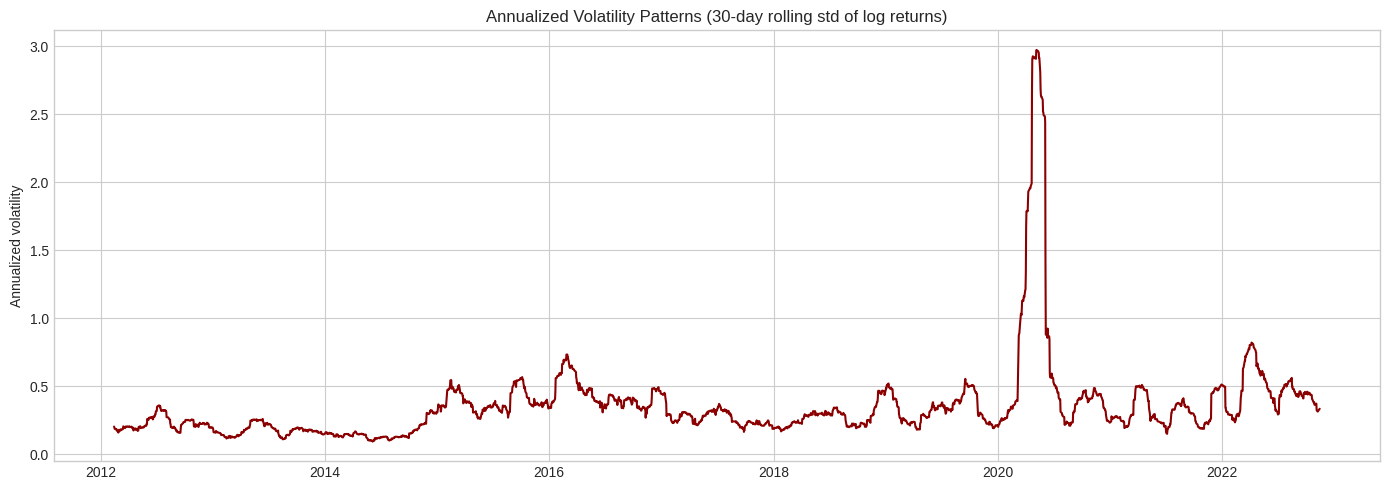

Narrative: Volatility clusters during crises (e.g., 2014–2016 glut, 2020 COVID, 2022 Ukraine). This informs that change point models could be extended to variance shifts in future work.


In [14]:
# Cell 5 – Volatility patterns: rolling std dev of log returns
vol = df['log_return'].rolling(30).std() * np.sqrt(252)  # annualized
vol_clean = vol.dropna()
dates_vol = df.index[-len(vol_clean):]

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(dates_vol, vol_clean, color='darkred', lw=1.5)
ax.set_title('Annualized Volatility Patterns (30-day rolling std of log returns)')
ax.set_ylabel('Annualized volatility')
plt.tight_layout()
plt.show()

print("Narrative: Volatility clusters during crises (e.g., 2014–2016 glut, 2020 COVID, 2022 Ukraine). This informs that change point models could be extended to variance shifts in future work.")

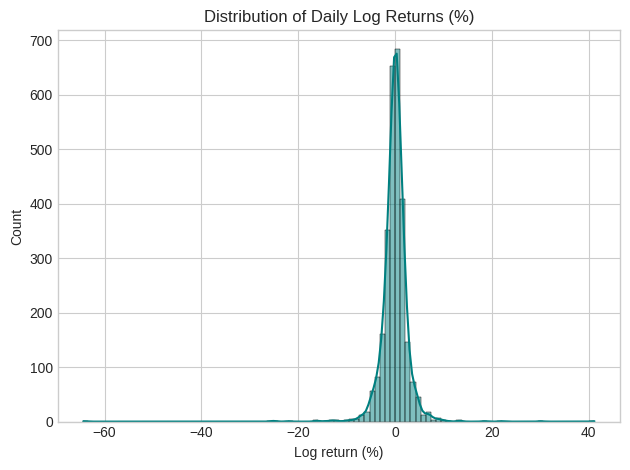

Narrative: Distribution shows fat tails (high kurtosis), typical of financial series with volatility clustering. This supports Bayesian modeling to capture uncertainty in regimes.


In [15]:
# Cell 6 – Log returns distribution for volatility insight
sns.histplot(df['log_return'].dropna() * 100, bins=100, kde=True, color='teal')
plt.title('Distribution of Daily Log Returns (%)')
plt.xlabel('Log return (%)')
plt.tight_layout()
plt.show()

print("Narrative: Distribution shows fat tails (high kurtosis), typical of financial series with volatility clustering. This supports Bayesian modeling to capture uncertainty in regimes.")